<a href="https://colab.research.google.com/github/katrin2202/text-summarization-in-nlp/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронки LSTM

In [1]:
#@title Скачиваем нужные библиотеки
%%capture
!pip install nltk
!pip install datasets
!pip install keras
!pip install keras_preprocessing

In [2]:
#@title Подключение библиотек
import numpy as np
import pandas as pd  
import re
import datasets
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# import warnings
# from attention import AttentionLayer
# pd.set_option("display.max_colwidth", 200)
# warnings.filterwarnings("ignore")

In [3]:
#@title Загрузка датасета
data_test=pd.read_csv("my-dataset-val.csv")
data_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12103 entries, 0 to 12102
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   summ    12103 non-null  object
 1   text    12103 non-null  object
dtypes: object(2)
memory usage: 189.2+ KB


In [ ]:
dataset = load_dataset('csv', data_files={'train': 'my-dataset-train.csv', 'val': 'my-dataset-val.csv', 'test': 'my-dataset-test.csv'})
dataset

In [4]:
#@title Загрузка стоп слов
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("russian"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
#@title Функция очистки текстов и результатов
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    # newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Zа-яА-Я]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()


In [ ]:
#@title Очистка данных text
cleaned_text = []
for t in data_test['text']:
    cleaned_text.append(text_cleaner(t,0))
cleaned_text[:5]  

In [ ]:
#@title Очистка данных summ
cleaned_summary = []
for t in data_test['summ']:
    cleaned_summary.append(text_cleaner(t,1))
cleaned_summary[:10]

In [8]:
#@title Дабавляем очищенные данные в датасет
data_test['cleaned_text']=cleaned_text
data_test['cleaned_summary']=cleaned_summary

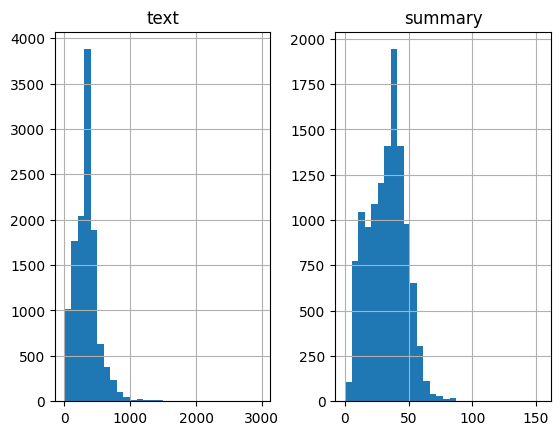

In [9]:
#@title Визуализация данных
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data_test['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data_test['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [10]:
#@title Процент обобщенного текста в котором меньше 25 слов
cnt=0
for i in data_test['cleaned_summary']:
    if(len(i.split())<=50):
        cnt=cnt+1
print(round(cnt/len(data_test['cleaned_summary'])*10000) / 100)

88.85


In [11]:
#@title Процент исходного текста меньше 100 слов
cnt=0
for i in data_test['cleaned_text']:
    if(len(i.split())<=500):
        cnt=cnt+1
print(round(cnt/len(data_test['cleaned_text'])*10000) / 100)

87.47


In [12]:
#@title Максимальная длина текста
max_text_len=500
max_summary_len=50

In [13]:
#@title Избавимся от выборосов
cleaned_text =np.array(data_test['cleaned_text'])
cleaned_summary=np.array(data_test['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [14]:
#@title Добавление маркеров в начале и в конце сводки
df['summary'] = df['summary'].apply(lambda x : 'старток '+ x + ' ендток')
for i in range(5):
    print("Review:",df['text'][i])
    print("Summary:",df['summary'][i])
    print("\n")

Review: выберите нужный товар затем нажмите кнопку оплатить купить выиграли предмет аукционе снова придется нажать кнопку pay now buy now вместо оплаты дебетовой кредитной картой paypal нажмите кнопку погашения подарочной карты сертификата купона перенаправят страницу нужно ввести код подарочных картах сертификатах купонах код который необходимо ввести ebay код либо прислан электронной почте либо напечатан обратной стороне карты введите код предоставленное поле нажмите погасить нажмите кнопку применить затем кнопку далее попросят войти свой аккаунт сделали собственного аккаунта закажите товар гостевой аккаунт случае придется указать адрес доставки проверьте данные убедитесь правильности адреса доставки имени номера телефона прочей информации затем нажмите кнопку подтвердить платеж завершить заказ
Summary: старток откройте раздел музыки вашей библиотеке itunes перейдите на вкладку itunes store нажмите ссылку бесплатно на itunes меню справа просмотрите выбор бесплатных музыкальных телеви

In [15]:
#@title Разделение на text и summary
# x_tr, y_tr = data_test['text'], data_test['summ']

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.05,random_state=0,shuffle=True) 

In [16]:
#@title Подготовка токенизатора для анализа данных обучения
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [17]:
#@title Подсчет количества редких и общеупотребительных слов в text
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% из редких слов в словаре:", round((cnt/tot_cnt)*10000)/100)
print("Общий охват редких слов:", round((freq/tot_freq)*10000)/100)

% из редких слов в словаре: 64.44
Общий охват редких слов: 6.64


In [18]:
#@title Определение токенизатора с помощью наиболее распространенных слов для обзоров
#подготовка токенизатора для обзоров по данным обучения
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#преобразование текстовых последовательностей в целочисленные последовательности
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#заполнение нуля до максимальной длины
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#размер словарного запаса ( +1 для маркера заполнения)
x_voc   =  x_tokenizer.num_words + 1

In [19]:
x_voc

63801

In [20]:
#@title Подготовка токенизатора для summary по данным обучения
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [21]:
#@title Подсчет количества редких и общеупотребительных слов в summary
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:", round((cnt/tot_cnt)*10000)/100)
print("Total Coverage of rare words:", round((freq/tot_freq)*10000)/100)

% of rare words in vocabulary: 85.29
Total Coverage of rare words: 25.23


In [22]:
#@title Определение токенизатора с помощью наиболее распространенных слов для обзоров
#подготовка токенизатора для обзоров по данным обучения
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#преобразование текстовых последовательностей в целочисленные последовательности
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#заполнение нуля до максимальной длины
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#размер словарного запаса ( +1 для маркера заполнения)
y_voc  =   y_tokenizer.num_words +1

In [23]:
#@title Количество контрольных слов в стартовом токене равно длине обучающих данных
y_tokenizer.word_counts['старток'],len(y_tr)

(8932, 8932)

In [24]:
#@title Удаление строк из train, содержащих только начальные и конечные токены
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [25]:
#@title Удаление строк из test, содержащих только начальные и конечные токены
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [26]:
#@title Построение модели, определение уровней LSTM, кодировщик и декодер
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# встраивающий слой
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Настройте декодер, используя `encoder_states` в качестве начального состояния.
decoder_inputs = Input(shape=(None,))

# встраивающий слой
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Слой внимания
# attn_layer = AttentionLayer(name='attention_layer')
# attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Объединенный входной сигнал и выход LSTM декодера
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs])

# плотный слой
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Определите модель
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 100)     6380100     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 500, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [27]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [28]:
#@title Мониторинг потери валидации
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2), 
      ModelCheckpoint('./MyModel_tf',monitor='val_loss', verbose=1,
                      save_best_only=True, mode='min', save_weights_only = False)]

In [ ]:
#@title Обучает модель в пакете размером 512 и проверяет ее на 10% набора данных
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,\
                  epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50


In [ ]:
# сериализует модель в JSON
model_json = model.to_json()
with open("summary.json", "w") as json_file:
    json_file.write(model_json)
# Сохраненная модель на диск
model.save_weights("summary.h5")
print("Saved model to disk")